In [ ]:
#импорт библиотек
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image

import warnings

warnings.simplefilter('ignore')

import torch as t
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms



import matplotlib.pyplot as plt
%matplotlib inline



from tqdm import tqdm

t.manual_seed(3704)
t.cuda.manual_seed(3704)
np.random.seed(3704)

In [ ]:
#Подгружаем датасеты
data_labels = pd.read_csv('train.csv', index_col=0)
data_labels = data_labels.reset_index(drop=True)

In [ ]:
data_labels['labels'].value_counts()

water     120
car        86
cloud      79
food       53
flower     49
dance      41
animal     41
sunset     35
fire       16
Name: labels, dtype: int64

In [ ]:
#Удалим лишние непонятные классы
data_labels[data_labels['labels'] == 'cloud, sunset'], data_labels[data_labels['labels'] == 'cloud, water']

(                                       path         labels
 162  Cell_Tower_at_Sunset_CLOSE_preview.mp4  cloud, sunset,
                                             path        labels
 342  Louisiana lake with landscaping_preview.mp4  cloud, water)

In [ ]:
data_labels = data_labels.drop([162,342]).reset_index(drop=True)
data_labels

,path,labels
0,France Argentiere church and cross with Alps_p...,cloud
1,Georgia Okefenokee reflections in scummy water...,water
2,170728_Berlin_A_012_preview.mp4,sunset
3,170209D_039_Diving_1080p_preview.mp4,water
4,motionplaces flower-Oct2018_preview.mp4,flower
...,...,...
515,190212_03_MarrakechKoutoubia_HD_07_preview.mp4,water
516,170609_B_DelhiJamaMasjid_004_preview.mp4,food
517,034660478-berlin-reichstag-backlit-drama_previ...,cloud
518,California smoke in evening sky_preview.mp4,cloud


In [ ]:
#Видео не повторяются
data_labels.nunique()

path      520
labels      9
dtype: int64

In [ ]:
#подготовим словарь перевода классов
cls = {'water': 0, 'car': 1, 'cloud': 2, 'food': 3, 'flower': 4, 'dance': 5, 'animal': 6, 'sunset': 7, 'fire': 8}

In [ ]:
#Веса классов
weights = 200 / data_labels['labels'].value_counts().values
weights

array([ 1.66666667,  2.3255814 ,  2.53164557,  3.77358491,  4.08163265,
        4.87804878,  4.87804878,  5.71428571, 12.5       ])

In [ ]:
#Делим датасет на train и val в отношении 1 к 7, классы в выборках сохраняют соотношение
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=8, random_state=0, shuffle=True)
for x,y in skf.split(data_labels.path, data_labels.labels):
    break
data_train = data_labels.iloc[x].reset_index(drop=True)
data_test = data_labels.iloc[y].reset_index(drop=True)
data_train

,path,labels
0,France Argentiere church and cross with Alps_p...,cloud
1,Georgia Okefenokee reflections in scummy water...,water
2,170728_Berlin_A_012_preview.mp4,sunset
3,170209D_039_Diving_1080p_preview.mp4,water
4,motionplaces flower-Oct2018_preview.mp4,flower
...,...,...
450,190212_03_MarrakechKoutoubia_HD_07_preview.mp4,water
451,170609_B_DelhiJamaMasjid_004_preview.mp4,food
452,034660478-berlin-reichstag-backlit-drama_previ...,cloud
453,California smoke in evening sky_preview.mp4,cloud


In [ ]:
#Подготовленная за меня функция
def read_video(path, img_size, frames_num):
    frames = []
    cap = cv2.VideoCapture(path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    N = length // (frames_num)

    current_frame = 1
    for i in range(length):
        ret, frame = cap.read(current_frame)

        if ret and i == current_frame and len(frames) < frames_num:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, img_size)

            frames.append(frame)
            current_frame += N

    cap.release()

    return frames

In [ ]:
def to_numpy_image(img, s, m):
    return (img.detach().cpu()* s + m).transpose(0, 1).transpose(1, 2).numpy() 

In [ ]:
#Будем чуть уменьшать фотки и рандомно аугментировать
#img_x = 430
#img_y = 240
img_x = 224
img_y = 224

In [ ]:
class Data_iter(Dataset):
    def __init__(self, data, col_fr, train):
        self.train_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.TrivialAugmentWide(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.valid_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.train = train
        self.data = data
        self.images = []
        self.labels = []
        for i in range(len(data)):
            for o in np.array(read_video(f'train/{data.iloc[i].path}', (430, 240), col_fr)):
                self.images.append(o)
            for o in range(col_fr):
                self.labels.append(cls[data.iloc[i].labels])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        img = Image.fromarray(self.images[idx], 'RGB')
        if(self.train):
            x = self.train_transform(img).view(3, img_y, img_x)
        else:
            x = self.valid_transform(img).view(3, img_y, img_x)   
        return x, self.labels[idx]


In [ ]:
#Для обучения берем по 2 фотки из train датасета. 
#В val-е будем брать по 3 фотографии от видео, для каждой делаем предсказание. Итоговый вердикт - наиболее частый класс
photo_train = Data_iter(data_train, 2, True)
loader_train = DataLoader(photo_train, batch_size=16, shuffle=True)
photo_test = Data_iter(data_test, 3, False)
loader_test = DataLoader(photo_test, batch_size=3, shuffle=False)

In [ ]:
#Используем модель efficientnet_b4, в ней нужно немного нормировать картинки
s = t.tensor([0.229, 0.224, 0.225]).view(3,1,1)
m = t.tensor([0.485, 0.456, 0.406]).view(3,1,1)

0


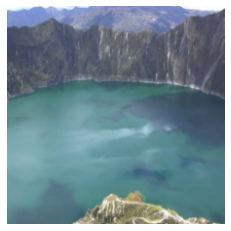

In [ ]:
#пример фоток из test-a
test = to_numpy_image(photo_test[0][0], s, m)
print(photo_test[0][1])
plt.axis('off')
plt.imshow(test)
plt.show()

2


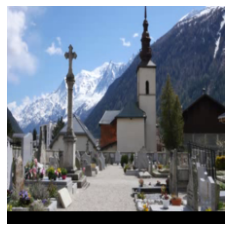

In [ ]:
#И из train-a
plt.imshow(to_numpy_image(photo_train[0][0], s, m))
print(photo_train[0][1])
plt.axis('off')
plt.show()

In [ ]:
from torchvision.models import efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3, efficientnet_b4, efficientnet_b5
# 1280 1280 1408 1536 1792 2048

In [ ]:
#Моделька
device = t.device('cuda:0')
num_epochs = 50
lr = 0.0001

model = efficientnet_b4(pretrained = True)
model.classifier[1] = nn.Linear(in_features=1792, out_features=9)
model = model.to(device)
#model.load_state_dict(torch.load('weights_droput_600.pt'))
optimizer = t.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(weight=t.tensor(weights, dtype=t.float32).to(device))


In [ ]:
#Веса классов
t.tensor(weights, dtype=t.float32)

tensor([ 1.6667,  2.3256,  2.5316,  3.7736,  4.0816,  4.8780,  4.8780,  5.7143,
        12.5000])

In [ ]:
#Понадобится отдельно
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1,1)

In [ ]:
#Функция для расчета accuracy
def check(model, val):
    model.eval()
    total = 0
    correct = 0
    for x,y in val:
        x = x.to(device)
        y_pred = model(x)
        res = softmax(y_pred.cpu().detach().numpy())
        total += 1
        correct += int(pd.Series(res.argmax(axis=1)).value_counts().index[0] == y.numpy()[0])
    return correct / total


In [ ]:
#Обучение!
#Я сохранял модель каждый раз , когда accuracy > 0.85, а потом выбрал лучшую 
h_loss = np.array([])
h_acc_tr = np.array([])
h_acc_tes = np.array([])
gradients = np.array([])
for epoch in range(num_epochs):
    model.train()
    total = 0
    correct = 0
    for x, y in loader_train:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        
        h_loss = np.append(h_loss, loss.item())
        
        #gradients = np.append(gradients,nn.utils.clip_grad_norm_(model.parameters(), 0.5).item())
        optimizer.step()
        res = softmax(pred.cpu().detach().numpy())
        total += res.shape[0]
        correct += (res.argmax(axis=1) == y.cpu().detach().numpy()).sum()
    
    h_acc_tr = np.append(h_acc_tr, correct / total)
    h_acc_tes = np.append(h_acc_tes, check(model, loader_test))
    print(epoch, h_loss[-1], h_acc_tes[-1])

    if(h_acc_tes[-1] > 0.85):
      t.save(model, f'model_b1_tr2_val3_8fold_sc{h_acc_tes[-1]//0.001/1000}_ep{epoch}.pt')





0 2.155435800552368 0.5846153846153846
1 2.003828525543213 0.6461538461538462
2 1.7727844715118408 0.7076923076923077
3 1.5590237379074097 0.7230769230769231
4 1.253623604774475 0.7846153846153846
5 0.8189795017242432 0.7692307692307693
6 0.9713073968887329 0.7538461538461538
7 0.8049408197402954 0.8307692307692308
8 0.8743436336517334 0.8
9 0.6169800162315369 0.7846153846153846
10 0.612819492816925 0.7846153846153846
11 0.33880415558815 0.8
12 0.18686002492904663 0.8153846153846154
13 0.25368043780326843 0.8
14 0.9307559728622437 0.8
15 0.2984527051448822 0.8153846153846154
16 0.18558251857757568 0.8
17 0.32714369893074036 0.8153846153846154
18 0.09054703265428543 0.8461538461538461
19 0.2872421443462372 0.7846153846153846
20 1.3846062421798706 0.8
21 0.0904407873749733 0.8307692307692308
22 0.9507359862327576 0.8
23 0.027861904352903366 0.8307692307692308
24 0.05948212742805481 0.8615384615384616
25 0.32628342509269714 0.8
26 0.40704330801963806 0.8153846153846154
27 0.39187082648277

In [ ]:
#Мне пнравилось модель на 24 моделе. Её я и отправил

tensor(2)


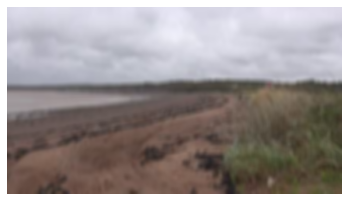

In [ ]:
#для прикола посмотреть, что выдает train loader
for x,y in loader_train:
    print(y[0])
    plt.axis('off')
    plt.imshow(to_numpy_image(x[0], s, m))
    plt.show()
    break

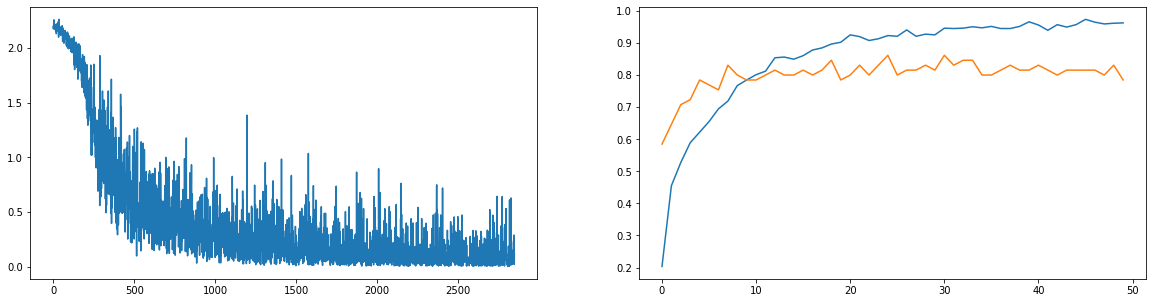

In [ ]:
#Графики обучения модели
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
ax1.plot(h_loss)
ax2.plot(h_acc_tr)
ax2.plot(h_acc_tes)

In [ ]:
#Дальше уже не столь интересные ячейки

In [ ]:
#data_check = photo_train 
data_check = photo_test


In [ ]:
pd.Series(yy[yy != yp]).value_counts()

0.0    15
4.0     8
1.0     7
7.0     7
2.0     6
3.0     6
6.0     6
5.0     3
dtype: int64

In [ ]:
yy = np.array([])
yp = np.array([])
for i in range(len(photo_test)):
  y_pred = softmax(model(data_check[i][0].view(1,3,img_y, img_x).to(device)).cpu().detach().numpy())
  yy = np.append(yy, data_check[i][1])
  yp = np.append(yp, softmax(y_pred).argmax())


1 0
7 0
7 0
7 0
0 0


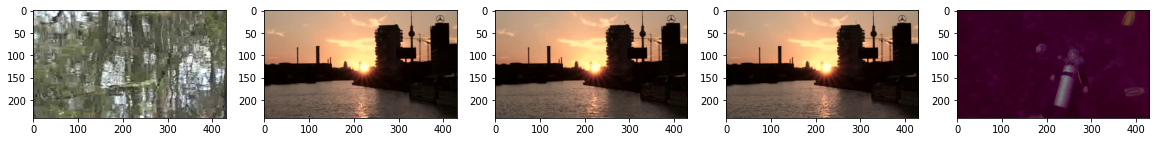

In [ ]:
model.eval()
idx = 5*1

for i in range(5):
  y_pred = softmax(model(data_check[idx + i][0].view(1,3,img_y, img_x).to(device)).cpu().detach().numpy())
  print(softmax(y_pred).argmax(), data_check[idx][1])


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
fig.set_figheight(4)
fig.set_figwidth(20)
ax1.imshow(to_numpy_image(data_check[idx+0][0], s, m))
ax2.imshow(to_numpy_image(data_check[idx+1][0], s, m))
ax3.imshow(to_numpy_image(data_check[idx+2][0], s, m))
ax4.imshow(to_numpy_image(data_check[idx+3][0], s, m))
ax5.imshow(to_numpy_image(data_check[idx+4][0], s, m))


In [ ]:
#t.save(model.state_dict(), f'weights_nodropout_600.pt')

In [ ]:
#t.save(pd.DataFrame(), f'dataframe.pt')